# QR-разложение вращениями Гивенса

## 0. Общая часть

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg.blas
import mymodule
from numba import njit

In [2]:
scipy.ALLOW_THREADS = 1
np.ALLOW_THREADS = 1

In [3]:
def restore_q(q):
    size = int((1 + np.sqrt(1 + 4*q.shape[0]))/2)
    res = np.eye(size)
    iq = q.shape[0] - 1
    for i in range(size-2, -1, -1,):
        for j in range(size-1, i, -1):
            s = q[iq]
            c = q[iq-1]
            scipy.linalg.blas.drot(res[i], res[j], c, -s, offx=i, offy=i, overwrite_x=1, overwrite_y=1)
            iq -= 2
    return res

def test(qr_func):
    eps = 1e-10
    size = 100
    a = np.random.rand(size, size)
    a_ = np.copy(a)
    q = restore_q(qr_func(a))
    for i in range(size-1):
        for j in range(i+1, size):
            if (a[j,i] > eps):
                return 1
    if np.linalg.norm(q@a - a_, ord='fro') > eps:
        return 2
    if np.linalg.norm(q@q.T - np.eye(size), ord='fro') > eps:
        return 3
    return 0

def compute_times(sizes, qr_func):
    times = []
    for size in sizes:
        a = np.random.rand(size, size)
        t = %timeit -o qr_func(a)
        times.append(t.average)
    return times

In [4]:
sizes = [64, 128, 256, 512]

## 1. Python

In [5]:
def compute_params(aii, aji):
    c =  aii / np.sqrt(aii * aii + aji * aji)
    s = -aji / np.sqrt(aii * aii + aji * aji)
    return (c, s)

def rotate(xi, xj, c, s):
    xi_ = xi * c - xj * s
    xj_ = xi * s + xj * c
    return (xi_, xj_)

def qr(a):
    size = a.shape[0]
    q = []
    for i in range(size-1):
        for j in range(i+1, size):
            c, s = compute_params(a[i, i], a[j, i])
            q.extend([c, -s])
            for k in range(i, size):
                xi, xj = rotate(a[i, k], a[j, k], c, s)
                a[i, k] = xi
                a[j, k] = xj
    return np.asarray(q)

In [6]:
test(qr)

0

In [7]:
res1 = compute_times(sizes, qr)

125 ms ± 25.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
979 ms ± 239 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.88 s ± 151 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1min 5s ± 7.19 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 2. Numpy

In [8]:
def qr_np(a):
    size = a.shape[0]
    q = []
    for i in range(size-1):
        for j in range(i+1, size):
            c, s = compute_params(a[i, i], a[j, i])
            ai = a[i] * c - a[j] * s
            aj = a[i] * s + a[j] * c
            a[i] = ai
            a[j] = aj
            q.extend([c, -s])
    return np.asarray(q)

In [9]:
test(qr_np)

0

In [10]:
res2 = compute_times(sizes, qr_np)

27.6 ms ± 7.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
140 ms ± 36.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
570 ms ± 103 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.06 s ± 742 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 3. Numpy + Numba

In [11]:
@njit
def qr_np_numba(a):
    size = a.shape[0]
    q = []
    for i in range(size-1):
        for j in range(i+1, size):
            c = a[i,i] / np.sqrt(a[i,i] * a[i,i] + a[j,i] * a[j,i])
            s = -a[j,i] / np.sqrt(a[i,i] * a[i,i] + a[j,i] * a[j,i])
            ai = a[i] * c - a[j] * s
            aj = a[i] * s + a[j] * c
            a[i] = ai
            a[j] = aj
            q.extend([c, -s])
    return np.asarray(q)

In [12]:
test(qr_np_numba)

0

In [13]:
res3 = compute_times(sizes, qr_np_numba)

2.66 ms ± 490 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
20.5 ms ± 4.08 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
168 ms ± 40.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
The slowest run took 5.30 times longer than the fastest. This could mean that an intermediate result is being cached.
204 ms ± 172 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 4. Numba

In [14]:
@njit
def qr_numba(a):
    size = a.shape[0]
    q_size = size * (size - 1)
    q = []
    for i in range(size-1):
        for j in range(i+1, size):
            aii = a[i, i]
            aji = a[j, i]
            c = aii / np.sqrt(aii * aii + aji * aji)
            s = -aji / np.sqrt(aii * aii + aji * aji)
            q.extend([c, -s])
            for k in range(i, size):
                xi = a[i, k]
                xj = a[j, k]
                a[i, k] = xi * c - xj * s
                a[j, k] = xi * s + xj * c
    return np.asarray(q)

In [15]:
test(qr_numba)

0

In [16]:
res4 = compute_times(sizes, qr_numba)

1.09 ms ± 244 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
13.4 ms ± 2.63 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
97.5 ms ± 6.22 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.17 s ± 239 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 5. SciPy

In [17]:
def qr_sp(a):
    size = a.shape[0]
    q = []
    for i in range(size-1):
        for j in range(i+1, size):
            c, s = scipy.linalg.blas.drotg(a[i,i], a[j,i])
            scipy.linalg.blas.drot(a[i], a[j], c, s, offx=i, offy=i, overwrite_x=1, overwrite_y=1)
            q.extend([c, s])
    return np.asarray(q)

In [18]:
test(qr_sp)

0

In [19]:
res5 = compute_times(sizes, qr_sp)

7.29 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
33.1 ms ± 6.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
119 ms ± 9.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
492 ms ± 25.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 6. C (swig)

In [20]:
# небольшой тест
size = 100
a = np.random.rand(size, size)
q = np.empty(size**2 - size)
a_ = np.copy(a)
mymodule.qr(a, q)
q = restore_q(q)
np.linalg.norm(q@a - a_, ord='fro')

5.426555094473649e-14

In [21]:
res6 = []
for size in sizes:
    a = np.random.rand(size, size)
    q = np.empty(size**2 - size)
    t = %timeit -o mymodule.qr(a, q)
    res6.append(t.average)

1.42 ms ± 319 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
9.94 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
68.8 ms ± 4.92 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
498 ms ± 95.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 7. Сравнение функций

In [22]:
labels = ['Python', 'NumPy', 'Numpy + Numba', 'Numba', 'SciPy', 'C (swig)']
colors = ['g', 'b', 'r', 'y', 'k', 'c']

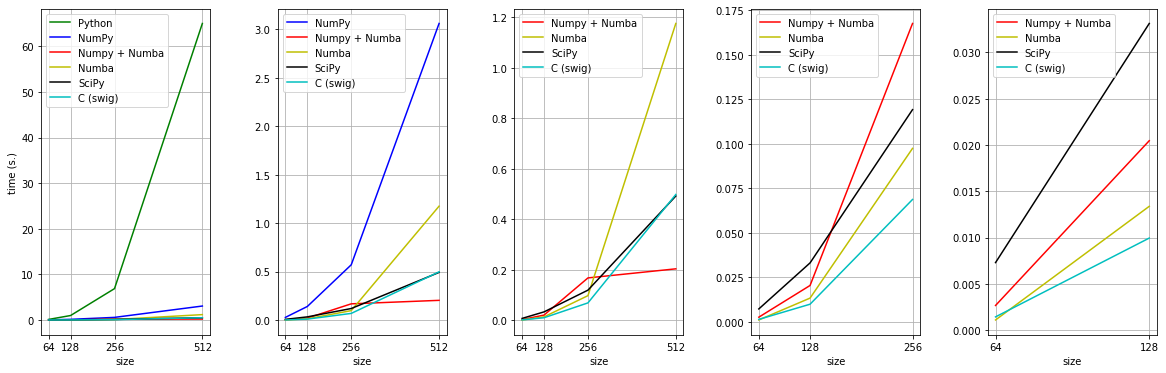

In [23]:
fig, ax = plt.subplots(1, 5, figsize=(20, 6))
for j in range(3):
    for i in range(j, len(labels)):
        ax[j].plot(sizes, eval('res%d'%(i+1)), label=labels[i], color=colors[i])
for i in range(2,len(labels)):
    ax[3].plot(sizes[:-1], eval('res%d[:-1]'%(i+1)), label=labels[i], color=colors[i])
for i in range(2, len(labels)):
    ax[4].plot(sizes[:-2], eval('res%d[:-2]'%(i+1)), label=labels[i], color=colors[i])
for i in range(5):
    ax[i].grid()
    ax[i].set_xlabel('size')
    ax[i].legend()
for i in range(3):  
    ax[i].set_xticks(sizes)
ax[0].set_ylabel('time (s.)')
ax[3].set_xticks(sizes[:-1])
ax[4].set_xticks(sizes[:-2])
plt.subplots_adjust(wspace=0.4)

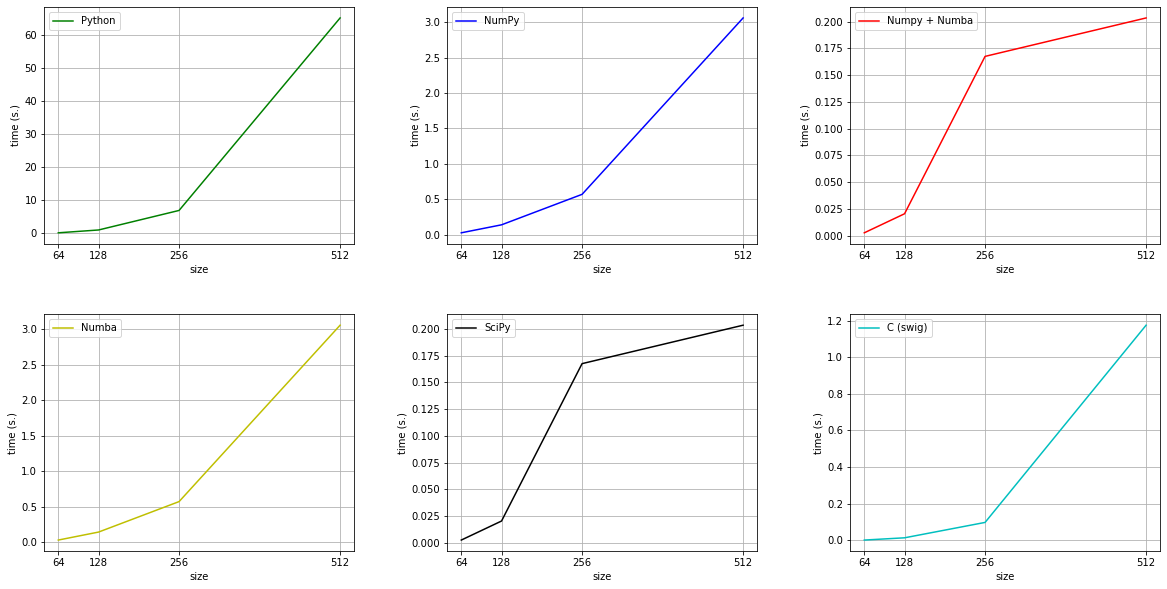

In [24]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
for i in range(2):
    for j in range(3):
        ax[i, j].set_xlabel('size')
        ax[i, j].set_ylabel('time (s.)')
        ax[i, j].plot(sizes, eval('res%d'%(i+j+1)), label=labels[3*i+j], color=colors[3*i+j])
        ax[i, j].legend(loc='upper left')
        ax[i, j].grid()
        ax[i, j].set_xticks(sizes)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()